In [7]:
!git clone https://github.com/google-research-datasets/Objectron

Cloning into 'Objectron'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 199 (delta 35), reused 29 (delta 29), pack-reused 160
Receiving objects: 100% (199/199), 40.03 MiB | 21.93 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [8]:
import numpy as np
import os
import requests
import struct
import sys
import subprocess
import cv2

from IPython.core.display import display,HTML
import matplotlib.pyplot as plt

# I'm running this Jupyter notebook locally. Manually import the objectron module.
module_path = os.path.abspath(os.path.join('Objectron/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The AR Metadata captured with each frame in the video
from objectron.schema import a_r_capture_metadata_pb2 as ar_metadata_protocol
# The annotations are stored in protocol buffer format. 
from objectron.schema import object_pb2 as object_protocol
from objectron.schema import annotation_data_pb2 as annotation_protocol
import objectron.dataset.box as Box

In [ ]:
public_url = "https://storage.googleapis.com/objectron"
blob_path = public_url + "/v1/index/shoe_annotations_train"
video_ids = requests.get(blob_path).text
video_ids = video_ids.split('\n')
# Download the first ten videos in cup test dataset
for i in range(1):
    video_filename = public_url + "/videos/" + video_ids[i] + "/video.MOV"
    metadata_filename = public_url + "/videos/" + video_ids[i] + "/geometry.pbdata"
    annotation_filename = public_url + "/annotations/" + video_ids[i] + ".pbdata"
    # video.content contains the video file.
    video = requests.get(video_filename)
    metadata = requests.get(metadata_filename)
    
    # Please refer to Parse Annotation tutorial to see how to parse the annotation files.
    annotation = requests.get(annotation_filename)
    
    file = open("video.MOV", "wb")
    file.write(video.content)
    file.close()
    
    file = open("geometry.pbdata", "wb")
    file.write(metadata.content)
    file.close()
    
    file = open("annotation.pbdata", "wb")
    file.write(annotation.content)
    file.close()

!ls

annotation.pbdata  drive  geometry.pbdata  Objectron  sample_data  video.MOV


In [ ]:
def get_geometry_data(geometry_filename):
    sequence_geometry = []
    with open(geometry_filename, 'rb') as pb:
        proto_buf = pb.read()

        i = 0
        frame_number = 0

        while i < len(proto_buf):
            # Read the first four Bytes in little endian '<' integers 'I' format
            # indicating the length of the current message.
            msg_len = struct.unpack('<I', proto_buf[i:i + 4])[0]
            i += 4
            message_buf = proto_buf[i:i + msg_len]
            i += msg_len
            frame_data = ar_metadata_protocol.ARFrame()
            frame_data.ParseFromString(message_buf)


            transform = np.reshape(frame_data.camera.transform, (4, 4))
            projection = np.reshape(frame_data.camera.projection_matrix , (4, 4))
            view = np.reshape(frame_data.camera.view_matrix , (4, 4))
            position = transform[:3, -1]

            current_points = [np.array([v.x, v.y, v.z])
                              for v in frame_data.raw_feature_points.point]
            current_points = np.array(current_points)

            sequence_geometry.append((transform, projection, view, current_points))
    return sequence_geometry


In [ ]:
def get_frame_annotation(annotation_filename):
    """Grab an annotated frame from the sequence."""
    result = []
    instances = []
    with open(annotation_filename, 'rb') as pb:
        sequence = annotation_protocol.Sequence()
        sequence.ParseFromString(pb.read())

        object_id = 0
        object_rotations = []
        object_translations = []
        object_scale = []
        num_keypoints_per_object = []
        object_categories = []
        annotation_types = []
        
        # Object instances in the world coordinate system, These are stored per sequence, 
        # To get the per-frame version, grab the transformed keypoints from each frame_annotation
        for obj in sequence.objects:
            rotation = np.array(obj.rotation).reshape(3, 3)
            translation = np.array(obj.translation)
            scale = np.array(obj.scale)
            points3d = np.array([[kp.x, kp.y, kp.z] for kp in obj.keypoints])
            instances.append((rotation, translation, scale, points3d))
        
        # Grab teh annotation results per frame
        for data in sequence.frame_annotations:
            # Get the camera for the current frame. We will use the camera to bring
            # the object from the world coordinate to the current camera coordinate.
            transform = np.array(data.camera.transform).reshape(4, 4)
            view = np.array(data.camera.view_matrix).reshape(4, 4)
            intrinsics = np.array(data.camera.intrinsics).reshape(3, 3)
            projection = np.array(data.camera.projection_matrix).reshape(4, 4)

            keypoint_size_list = []
            object_keypoints_2d = []
            object_keypoints_3d = []
            for annotations in data.annotations:
                num_keypoints = len(annotations.keypoints)
                keypoint_size_list.append(num_keypoints)
                for keypoint_id in range(num_keypoints):
                    keypoint = annotations.keypoints[keypoint_id]
                    object_keypoints_2d.append((keypoint.point_2d.x, keypoint.point_2d.y, keypoint.point_2d.depth))
                    object_keypoints_3d.append((keypoint.point_3d.x, keypoint.point_3d.y, keypoint.point_3d.z))
                num_keypoints_per_object.append(num_keypoints)
                object_id += 1
            result.append((object_keypoints_2d, object_keypoints_3d, keypoint_size_list, view, projection))

    return result, instances

In [ ]:
def grab_frame(video_file, frame_ids):
  """Grab an image frame from the video file."""
  frames = []
  capture = cv2.VideoCapture(video_file)
  height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
  capture.release()
  frame_size = width * height * 3

  for frame_id in frame_ids:
    frame_filter = r'select=\'eq(n\,{:d})\''.format(frame_id)
    command = [
        'ffmpeg', '-i', video_file, '-f', 'image2pipe', '-vf', frame_filter,
        '-pix_fmt', 'rgb24', '-vcodec', 'rawvideo', '-vsync', 'vfr', '-'
    ]
    pipe = subprocess.Popen(
        command, stdout=subprocess.PIPE, bufsize = 151 * frame_size)
    current_frame = np.frombuffer(
        pipe.stdout.read(frame_size), dtype='uint8').reshape(width, height, 3)
    pipe.stdout.flush()

    frames.append(current_frame)
  return frames

In [ ]:
def project_points(points, projection_matrix, view_matrix, width, height):
    p_3d = np.concatenate((points, np.ones_like(points[:, :1])), axis=-1).T
    p_3d_cam = np.matmul(view_matrix, p_3d)
    p_2d_proj = np.matmul(projection_matrix, p_3d_cam)
    # Project the points
    p_2d_ndc = p_2d_proj[:-1, :] / p_2d_proj[-1, :]
    p_2d_ndc = p_2d_ndc.T

    # Convert the 2D Projected points from the normalized device coordinates to pixel values
    x = p_2d_ndc[:, 1]
    y = p_2d_ndc[:, 0]
    pixels = np.copy(p_2d_ndc)
    pixels[:, 0] = ((1 + x) * 0.5) * width
    pixels[:, 1] = ((1 + y) * 0.5) * height    
    pixels = pixels.astype(int)
    return pixels

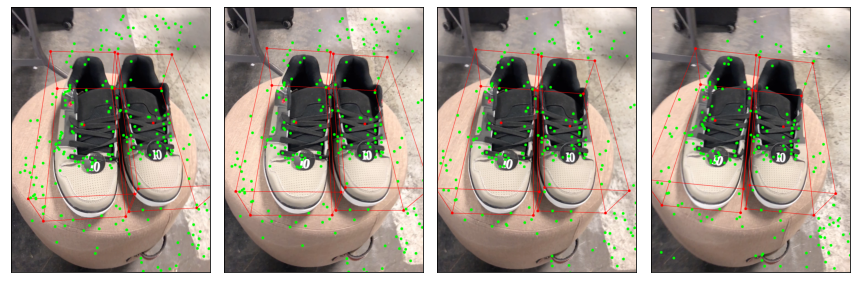

In [ ]:
# Grab some frames from the video file.
frame_ids = [100, 105, 110, 115]
num_frames = len(frame_ids)
sequence_geometry = get_geometry_data('geometry.pbdata')
frames = grab_frame('video.MOV', frame_ids)
annotation_data, instances = get_frame_annotation('annotation.pbdata')
fig, ax = plt.subplots(1, num_frames, figsize = (12, 16))

for i in range(len(frame_ids)):
    frame_id = frame_ids[i]    
    image = frames[i]
    height, width, _ = image.shape
    points_2d, points_3d, num_keypoints, frame_view_matrix, frame_projection_matrix = annotation_data[frame_id]
    num_instances = len(num_keypoints)
    
    
    # As covered in our previous tutorial, we can directly grab the 2D projected points from the annotation
    # file. The projections are normalized, so we scale them with the image's height and width to get 
    # the pixel value.
    # The keypoints are [x, y, d] where `x` and `y` are normalized (`uv`-system)\
    # and `d` is the metric distance from the center of the camera. Convert them
    # keypoint's `xy` value to pixel.
    points_2d = np.split(points_2d, np.array(np.cumsum(num_keypoints)))
    points_2d = [points.reshape(-1, 3) for points in points_2d]
    points_2d = [
        np.multiply(keypoint, np.asarray([width, height, 1.], np.float32)).astype(int)
        for keypoint in points_2d
    ]
    
    points_2d = []
    # Now, let's compute the box's vertices in 3D, then project them back to 2D:
    for instance_id in range(num_instances):
        # The annotation contains the box's transformation and scale in world coordinate system
        # Here the instance_vertices_3d are the box vertices in the "BOX" coordinate, (i.e. it's a unit box)
        # and has to be transformed to the world coordinate.
        instance_rotation, instance_translation, instance_scale, instance_vertices_3d = instances[instance_id]
        
        box_transformation = np.eye(4)
        box_transformation[:3, :3] = np.reshape(instance_rotation, (3, 3))
        box_transformation[:3, -1] = instance_translation
        vertices_3d = instance_vertices_3d * instance_scale.T;
        # Homogenize the points
        vertices_3d_homg = np.concatenate((vertices_3d, np.ones_like(vertices_3d[:, :1])), axis=-1).T
        # Transform the homogenious 3D vertices with the box transformation
        box_vertices_3d_world = np.matmul(box_transformation, vertices_3d_homg) 
        
        # If we transform these vertices to the camera frame, we get the 3D keypoints in the annotation data
        # i.e. vertices_3d_cam == points_3d
        vertices_3d_cam = np.matmul(frame_view_matrix, box_vertices_3d_world)
        vertices_2d_proj = np.matmul(frame_projection_matrix, vertices_3d_cam)
        
        # Project the points
        points2d_ndc = vertices_2d_proj[:-1, :] / vertices_2d_proj[-1, :]
        points2d_ndc = points2d_ndc.T
        
        # Convert the 2D Projected points from the normalized device coordinates to pixel values
        x = points2d_ndc[:, 1]
        y = points2d_ndc[:, 0]
        points2d = np.copy(points2d_ndc)
        points2d[:, 0] = ((1 + x) * 0.5) * width
        points2d[:, 1] = ((1 + y) * 0.5) * height
        points_2d.append(points2d.astype(int))
        # points2d are the projected 3D points on the image plane.
        
    # Visualize the boxes
    for instance_id in range(num_instances):
        for kp_id in range(num_keypoints[instance_id]):
          kp_pixel = points_2d[instance_id][kp_id, :]
          cv2.circle(image, (kp_pixel[0], kp_pixel[1]), 10, (255, 0, 0), -1)
        for edge in Box.EDGES:
            start_kp = points_2d[instance_id][edge[0], :]
            end_kp = points_2d[instance_id][edge[1], :]
            cv2.line(image, (start_kp[0], start_kp[1]), (end_kp[0], end_kp[1]), (255, 0, 0), 2)
        
    # We can also use the above pipeline to visualize the scene point-cloud on the image.
    # First, let's grab the point-cloud from the geometry metadata
    transform, projection, view, scene_points_3d = sequence_geometry[frame_id]
    scene_points_2d = project_points(scene_points_3d, projection, view, width, height)
    # Note these points all have estimated depth, which can double as a sparse depth map for the image.
    
    for point_id in range(scene_points_2d.shape[0]):
       cv2.circle(image, (scene_points_2d[point_id, 0], scene_points_2d[point_id, 1]), 10,
                      (0, 255, 0), -1)
    ax[i].grid(False)
    ax[i].imshow(image);
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
        
fig.tight_layout();
plt.show()

(315, 3)


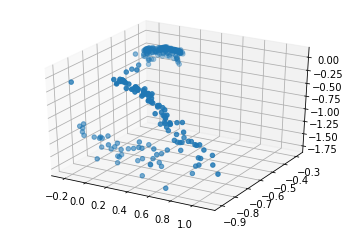

In [ ]:
frame_id = 100
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
transform, projection, view, points_3d = sequence_geometry[frame_id]
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])
print(points_3d.shape)

Objcectron Tutorial: Parsing Annotation Data

In [ ]:
annotation_file = '/content/annotation.pbdata'
video_filename = '/content/video.MOV'
# Along with the video.MOV file, there is a geometry.pbdata file that contains
# the geometry information of the scene (such as camera poses, point-clouds, and surfaces).
# There is a copy of this container within each annotation protobuf too.
geometry_filename = '/content/geometry.pbdata'# a.k.a. AR metadata

In [6]:
import glob
import os
import subprocess
from absl import app
from absl import flags

#import box as Box
import cv2
import numpy as np

from google.protobuf import text_format
from IPython.core.display import display,HTML
import matplotlib.pyplot as plt

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The annotations are stored in protocol buffer format. 
from objectron.schema import object_pb2 as object_protocol
from objectron.schema import annotation_data_pb2 as annotation_protocol
# The AR Metadata captured with each frame in the video
from objectron.schema import a_r_capture_metadata_pb2 as ar_metadata_protocol
from objectron.dataset import box as Box
from objectron.dataset import graphics

ModuleNotFoundError: ignored

In [ ]:
def get_frame_annotation(sequence, frame_id):
  """Grab an annotated frame from the sequence."""
  data = sequence.frame_annotations[frame_id]
  object_id = 0
  object_keypoints_2d = []
  object_keypoints_3d = []
  object_rotations = []
  object_translations = []
  object_scale = []
  num_keypoints_per_object = []
  object_categories = []
  annotation_types = []
  # Get the camera for the current frame. We will use the camera to bring
  # the object from the world coordinate to the current camera coordinate.
  camera = np.array(data.camera.transform).reshape(4, 4)

  for obj in sequence.objects:
    rotation = np.array(obj.rotation).reshape(3, 3)
    translation = np.array(obj.translation)
    object_scale.append(np.array(obj.scale))
    transformation = np.identity(4)
    transformation[:3, :3] = rotation
    transformation[:3, 3] = translation
    obj_cam = np.matmul(camera, transformation)
    object_translations.append(obj_cam[:3, 3])
    object_rotations.append(obj_cam[:3, :3])
    object_categories.append(obj.category)
    annotation_types.append(obj.type)

  keypoint_size_list = []
  for annotations in data.annotations:
    num_keypoints = len(annotations.keypoints)
    keypoint_size_list.append(num_keypoints)
    for keypoint_id in range(num_keypoints):
      keypoint = annotations.keypoints[keypoint_id]
      object_keypoints_2d.append(
          (keypoint.point_2d.x, keypoint.point_2d.y, keypoint.point_2d.depth))
      object_keypoints_3d.append(
          (keypoint.point_3d.x, keypoint.point_3d.y, keypoint.point_3d.z))
    num_keypoints_per_object.append(num_keypoints)
    object_id += 1
  return (object_keypoints_2d, object_categories, keypoint_size_list,
          annotation_types)

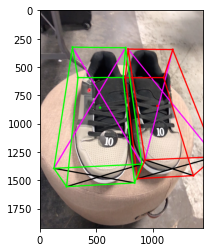

In [ ]:
frame_id = 100
with open(annotation_file, 'rb') as pb:
    sequence = annotation_protocol.Sequence()
    sequence.ParseFromString(pb.read())
    frame = grab_frame(video_filename, [frame_id])
    annotation, cat, num_keypoints, types = get_frame_annotation(sequence, frame_id)
    image = graphics.draw_annotation_on_image(frame[0], annotation, num_keypoints)
    imgplot = plt.imshow(image)


TEST POINTNET++


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
     |████████████████████████████████| 38.0 MB 13.1 MB/s 
     |████████████████████████████████| 190 kB 14.8 MB/s 


In [3]:
import mmcv
import numpy as np

class LoadPointsFromFile(object):
    """Load Points From File.

    Load points from file.

    Args:
        coord_type (str): The type of coordinates of points cloud.
            Available options includes:
            - 'LIDAR': Points in LiDAR coordinates.
            - 'DEPTH': Points in depth coordinates, usually for indoor dataset.
            - 'CAMERA': Points in camera coordinates.
        load_dim (int, optional): The dimension of the loaded points.
            Defaults to 6.
        use_dim (list[int], optional): Which dimensions of the points to use.
            Defaults to [0, 1, 2]. For KITTI dataset, set use_dim=4
            or use_dim=[0, 1, 2, 3] to use the intensity dimension.
        shift_height (bool, optional): Whether to use shifted height.
            Defaults to False.
        use_color (bool, optional): Whether to use color features.
            Defaults to False.
        file_client_args (dict, optional): Config dict of file clients,
            refer to
            https://github.com/open-mmlab/mmcv/blob/master/mmcv/fileio/file_client.py
            for more details. Defaults to dict(backend='disk').
    """

    def __init__(self,
                 coord_type,
                 load_dim=6,
                 use_dim=[0, 1, 2],
                 shift_height=False,
                 use_color=False,
                 file_client_args=dict(backend='disk')):
        self.shift_height = shift_height
        self.use_color = use_color
        if isinstance(use_dim, int):
            use_dim = list(range(use_dim))
        assert max(use_dim) < load_dim, \
            f'Expect all used dimensions < {load_dim}, got {use_dim}'
        assert coord_type in ['CAMERA', 'LIDAR', 'DEPTH']

        self.coord_type = coord_type
        self.load_dim = load_dim
        self.use_dim = use_dim
        self.file_client_args = file_client_args.copy()
        self.file_client = None

    def _load_points(self, pts_filename):
        """Private function to load point clouds data.

        Args:
            pts_filename (str): Filename of point clouds data.

        Returns:
            np.ndarray: An array containing point clouds data.
        """
        if self.file_client is None:
            self.file_client = mmcv.FileClient(**self.file_client_args)
        try:
            pts_bytes = self.file_client.get(pts_filename)
            points = np.frombuffer(pts_bytes, dtype=np.float32)
        except ConnectionError:
            mmcv.check_file_exist(pts_filename)
            if pts_filename.endswith('.npy'):
                points = np.load(pts_filename)
            else:
                points = np.fromfile(pts_filename, dtype=np.float32)

        return points

    def __call__(self, results):
        """Call function to load points data from file.

        Args:
            results (dict): Result dict containing point clouds data.

        Returns:
            dict: The result dict containing the point clouds data.
                Added key and value are described below.

                - points (:obj:`BasePoints`): Point clouds data.
        """
        pts_filename = results['pts_filename']
        points = self._load_points(pts_filename)
        points = points.reshape(-1, self.load_dim)
        points = points[:, self.use_dim]
        attribute_dims = None

        if self.shift_height:
            floor_height = np.percentile(points[:, 2], 0.99)
            height = points[:, 2] - floor_height
            points = np.concatenate(
                [points[:, :3],
                 np.expand_dims(height, 1), points[:, 3:]], 1)
            attribute_dims = dict(height=3)

        if self.use_color:
            assert len(self.use_dim) >= 6
            if attribute_dims is None:
                attribute_dims = dict()
            attribute_dims.update(
                dict(color=[
                    points.shape[1] - 3,
                    points.shape[1] - 2,
                    points.shape[1] - 1,
                ]))

        points_class = get_points_type(self.coord_type)
        points = points_class(
            points, points_dim=points.shape[-1], attribute_dims=attribute_dims)
        results['points'] = points

        return results

    def __repr__(self):
        """str: Return a string that describes the module."""
        repr_str = self.__class__.__name__ + '('
        repr_str += f'shift_height={self.shift_height}, '
        repr_str += f'use_color={self.use_color}, '
        repr_str += f'file_client_args={self.file_client_args}, '
        repr_str += f'load_dim={self.load_dim}, '
        repr_str += f'use_dim={self.use_dim})'
        return repr_str

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [4]:
testPoints = LoadPointsFromFile('DEPTH')

In [ ]:
binPoints = testPoints._load_points('/content/drive/MyDrive/mmdetection3d/data/sunrgbd/points/000001.bin')

In [ ]:
binPoints.shape

(300000,)

In [ ]:
binPoints = binPoints.reshape(-1, 3)

In [ ]:
binPoints.shape

(100000, 3)

(315, 3)


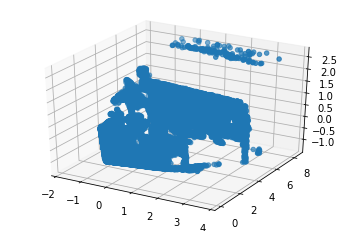

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(binPoints[:, 0], binPoints[:, 1], binPoints[:, 2])
print(points_3d.shape)

(315, 3)
[[-3.86895314e-02 -3.09774995e-01 -3.20169538e-01]
 [ 3.25252950e-01 -8.04583192e-01 -1.16455460e+00]
 [-1.46352500e-02 -3.29615891e-01 -1.09117121e-01]
 [ 1.14997318e-02 -3.36775869e-01 -1.30637184e-01]
 [ 3.52790743e-01 -8.07576180e-01 -1.26993799e+00]
 [ 4.60424051e-02 -3.23956788e-01 -1.60303578e-01]
 [ 4.86857183e-02 -3.22807550e-01 -1.48235068e-01]
 [ 8.50237012e-01 -8.07678998e-01 -1.40993023e+00]
 [-1.05534919e-01 -3.93423826e-01 -3.11125904e-01]
 [ 5.76944590e-01 -7.98070014e-01 -1.22704768e+00]
 [ 5.06479330e-02 -3.32656115e-01 -1.42627165e-01]
 [-4.65942211e-02 -3.40200007e-01 -1.27048209e-01]
 [ 7.64408782e-02 -3.35673779e-01 -1.31393507e-01]
 [ 1.10540056e+00 -8.51911843e-01 -1.38395858e+00]
 [ 1.11751541e-01 -3.26538682e-01 -1.54968828e-01]
 [ 9.14239824e-01 -8.23918581e-01 -1.20779693e+00]
 [-3.47356685e-02 -3.41224819e-01 -1.11076489e-01]
 [ 8.12657058e-01 -8.10589612e-01 -9.45123374e-01]
 [ 4.16501649e-02 -3.01773101e-01 -2.05951825e-01]
 [ 3.57539207e-01 -8.0

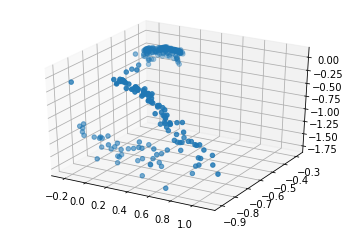

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])
print(points_3d.shape)
print(points_3d)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


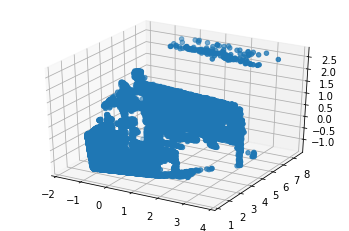

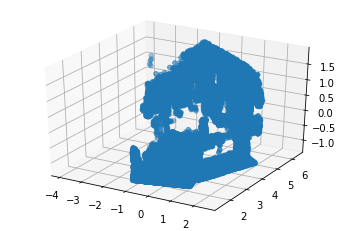

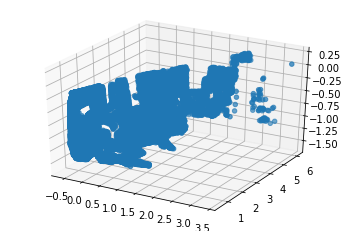

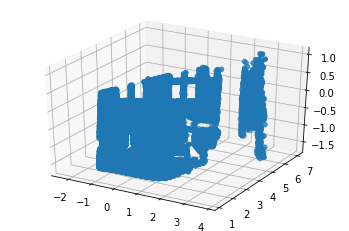

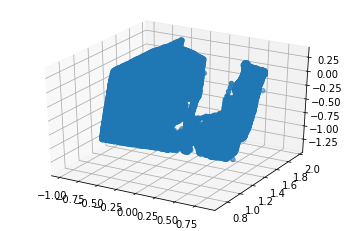

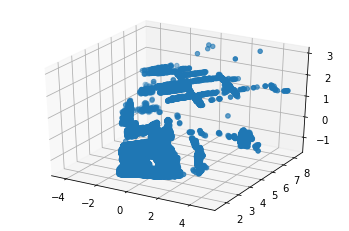

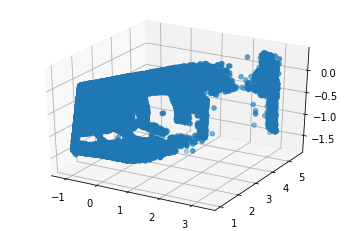

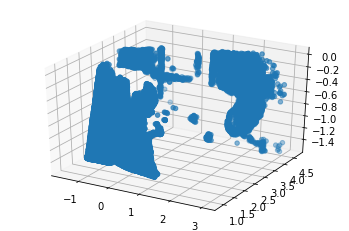

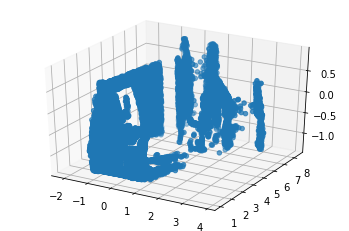

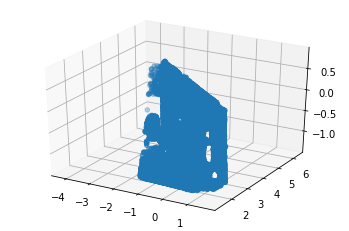

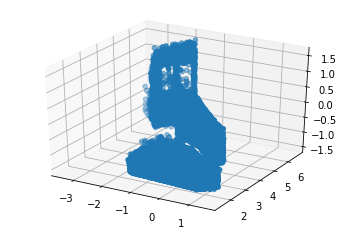

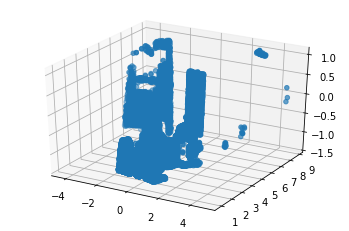

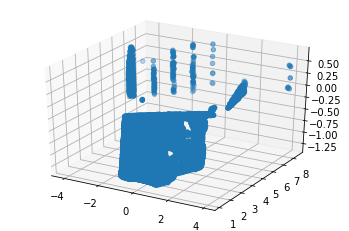

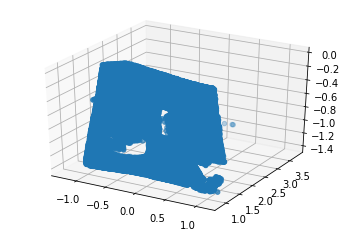

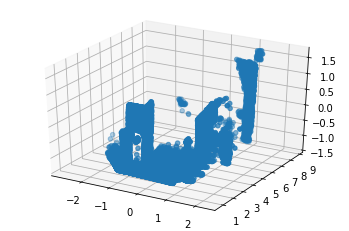

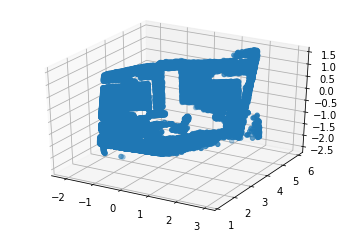

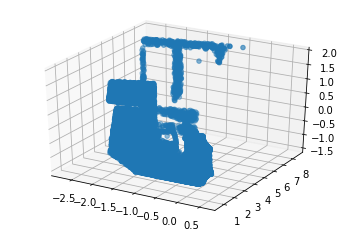

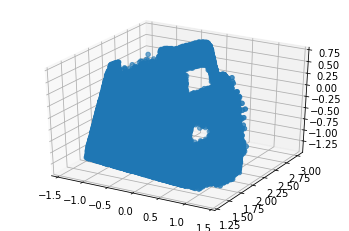

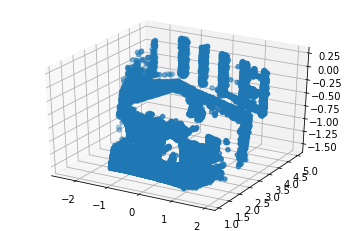

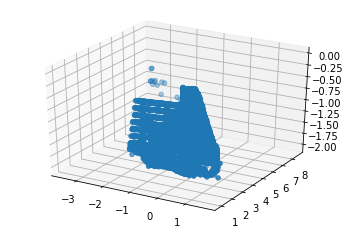

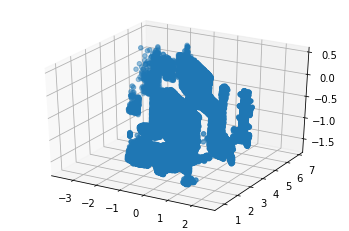

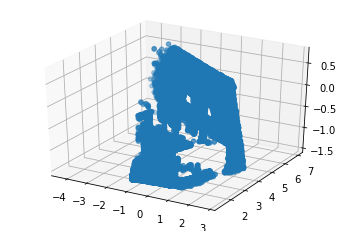

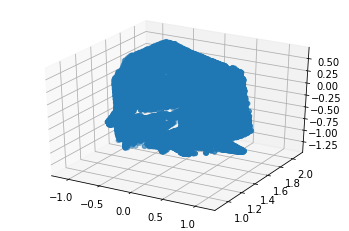

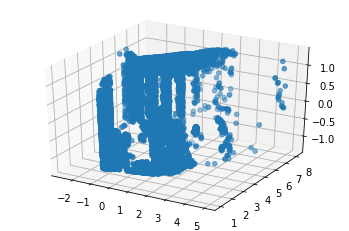

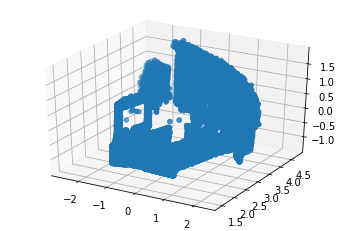

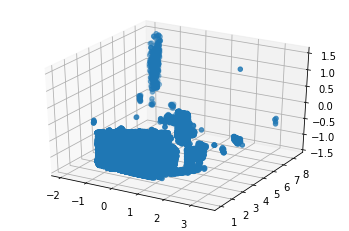

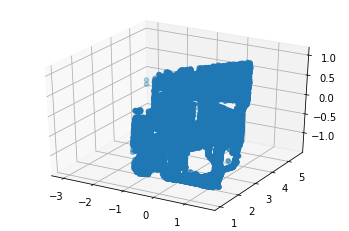

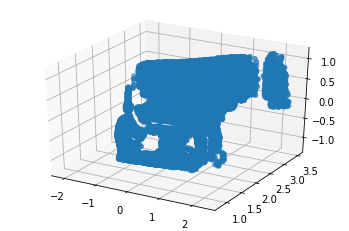

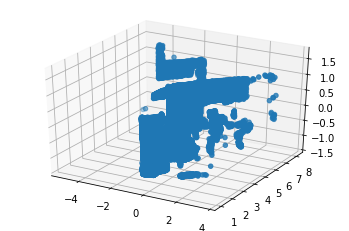

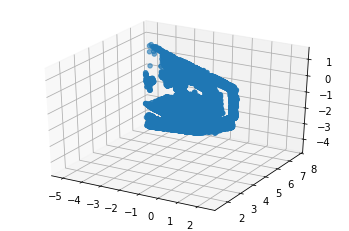

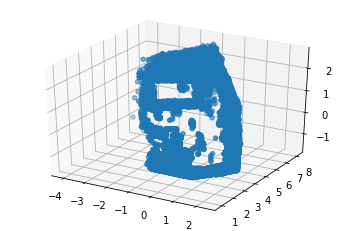

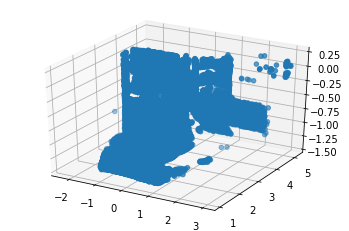

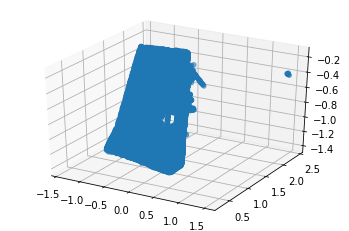

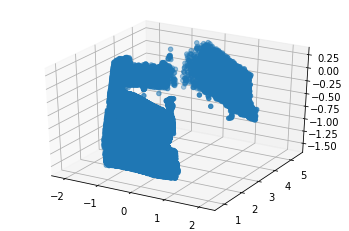

In [25]:
testPoints = LoadPointsFromFile('DEPTH')
for i in range(1, 1000, 30):
  binPoints = testPoints._load_points('/content/drive/MyDrive/mmdetection3d/data/sunrgbd/points/' + ('0' * (6 - len(str(i)))) + str(i) + '.bin')
  binPoints = binPoints.reshape(-1, 6)
  # print(str(i) + ': ' + str(binPoints.shape))
  # print(binPoints)
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(binPoints[:, 0], binPoints[:, 1], binPoints[:, 2])
  # break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


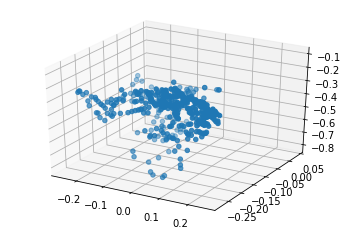

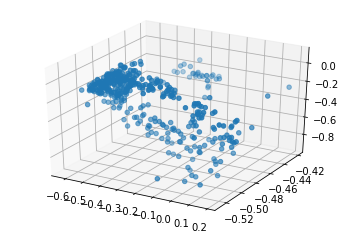

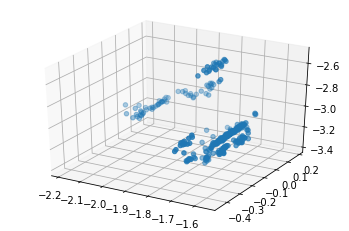

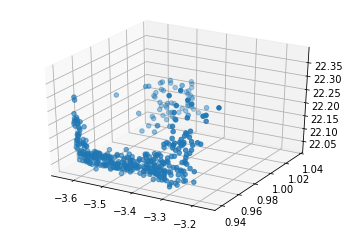

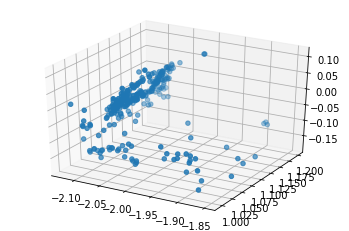

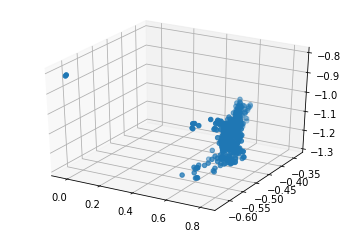

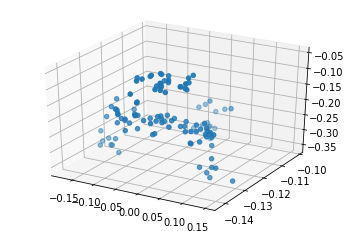

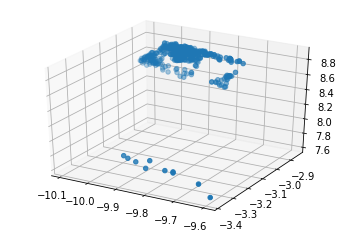

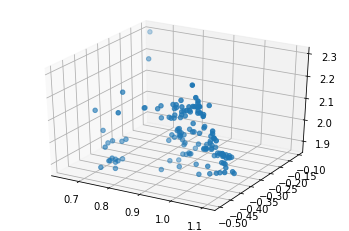

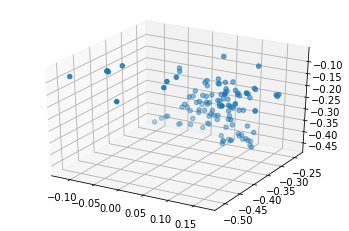

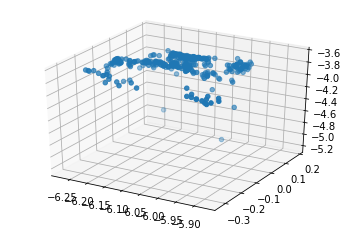

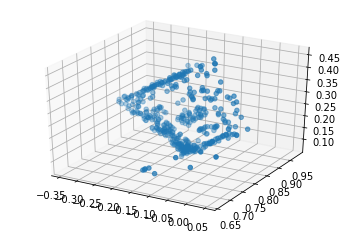

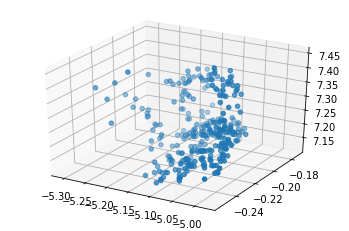

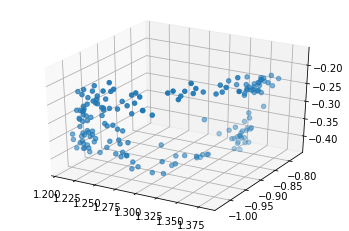

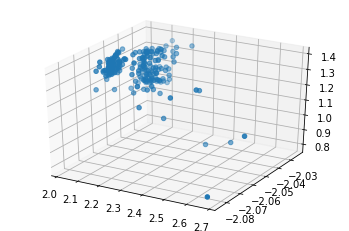

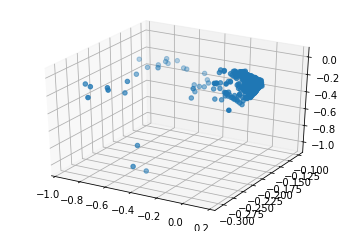

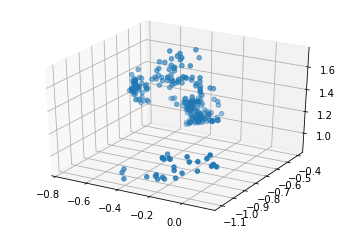

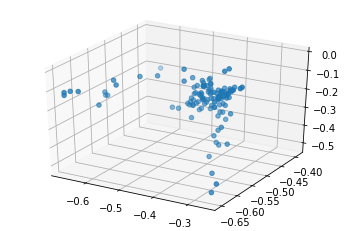

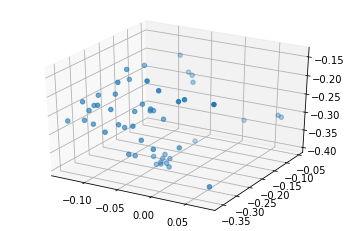

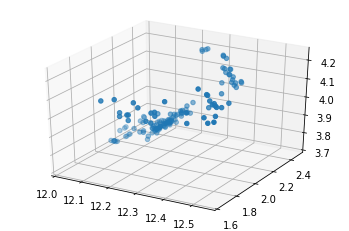

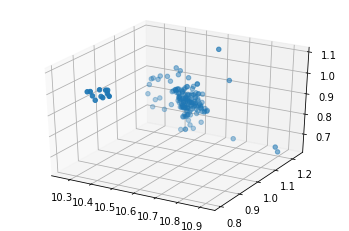

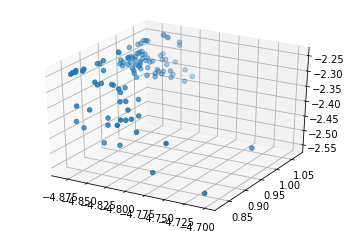

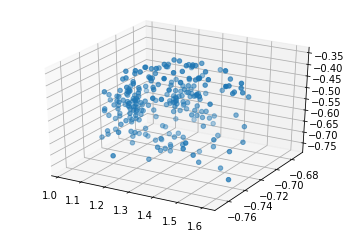

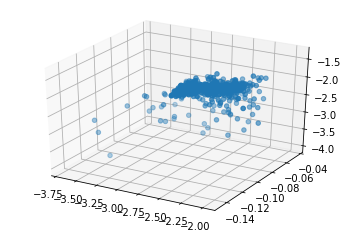

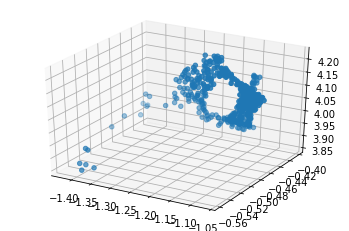

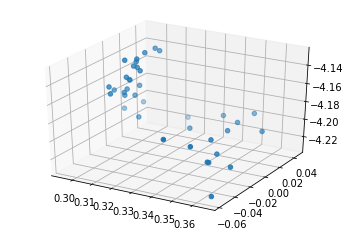

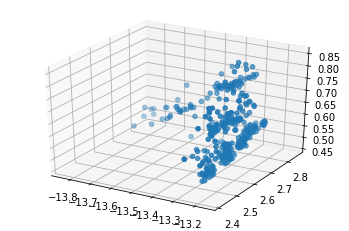

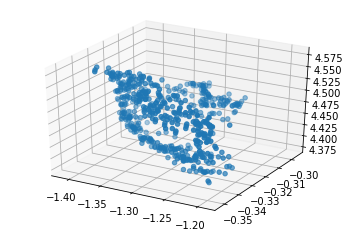

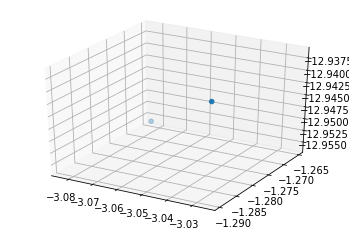

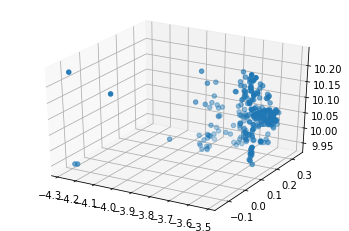

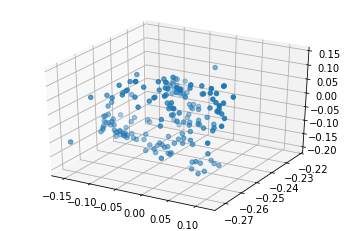

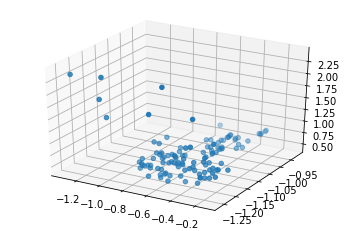

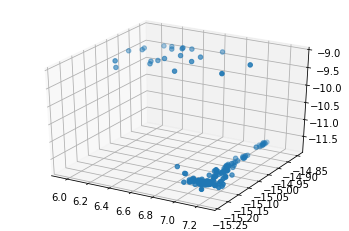

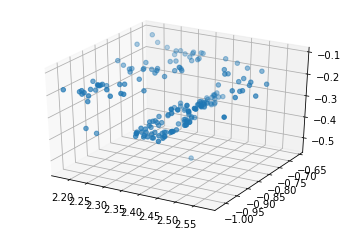

In [14]:
testPoints = LoadPointsFromFile('DEPTH')
for i in range(1, 1000, 30):
  binPoints = testPoints._load_points('/content/drive/MyDrive/Objectron-to-SUNRGBD3D-format/sunrgbd/points/' + ('0' * (6 - len(str(i)))) + str(i) + '.bin')
  binPoints = binPoints.reshape(-1, 3)
  # print(str(i) + ': ' + str(binPoints.shape))
  # print(binPoints)
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(binPoints[:, 0], binPoints[:, 1], binPoints[:, 2])
  # break

In [16]:
from scipy import io as sio

a = sio.loadmat('/content/drive/MyDrive/mmdetection3d/data/sunrgbd/sunrgbd_trainval/depth/000001.mat')

In [18]:
a['instance']

array([[-0.9563752 ,  1.3139229 ,  0.28012398,  0.31764707,  0.25490198,
         0.29803923],
       [-0.9811764 ,  1.3528353 ,  0.2582911 ,  0.29411766,  0.23137255,
         0.27450982],
       [-0.948279  ,  1.3089279 ,  0.24090429,  0.30588236,  0.22745098,
         0.27058825],
       ...,
       [ 3.8132794 ,  5.231323  , -0.664964  ,  0.8       ,  0.80784315,
         0.8039216 ],
       [ 3.7414453 ,  5.113158  , -0.6985009 ,  0.8       ,  0.80784315,
         0.8039216 ],
       [ 3.756353  ,  5.113939  , -0.74728763,  0.8       ,  0.80784315,
         0.8039216 ]], dtype=float32)

In [19]:
len(a['instance'])

280961

In [21]:
a['instance'].shape

(280961, 6)